In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU. This is important so things run faster.


In [3]:
class dataset:
    def __init__(self,data,target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.data[idx]
        y = self.target[idx]
        
        return X,y

In [4]:
data = np.load('data.npy',allow_pickle=True)
target = np.load('target.npy',allow_pickle=True)

In [5]:
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        try:
            data[i,j,10] = int(str(data[i,j,10])[0])
        except:
            data[i,j,10] = 0

In [6]:
for i in range(target.shape[0]):
    try:
        target[i,10] = int(str(target[i,10])[0])
    except:
        target[i,10] = 0

In [7]:
data = data.astype("float")
target = target.astype("float")

In [8]:
data = torch.from_numpy(data).float()
# data = data.permute(0,2,1) # Needed if using CNN
target = torch.from_numpy(target).float()

train_idx,test_idx = train_test_split(np.arange(data.shape[0]),test_size=0.1)
'''
0:Year,1:ProfitLoss,2:GrossResult,3:GrossProfitLoss,
4:Revenue,5:Assets,6:AverageNumberOfEmployees,7:CurrentAssets,8:Equity,
9:Inventories,10:AddressOfReportingEntityPostCodeIdentifier
'''
train_data = data[train_idx,:,1:]
train_target = target[train_idx,5] 
test_data = data[test_idx,:,1:]
test_target = target[test_idx,5]

trainset = dataset(train_data,train_target)
testset = dataset(test_data,test_target)

In [9]:
train_data.shape

torch.Size([30989, 3, 10])

In [10]:
batch_size=200

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

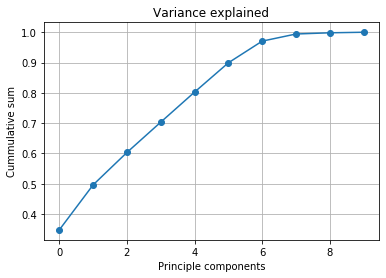

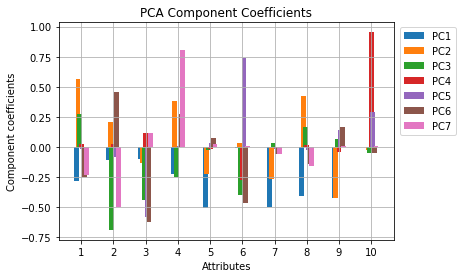

In [11]:
temp = data.clone()
temp = temp.view(temp.shape[0]*temp.shape[1],temp.shape[2])
temp = temp[:,1:temp.shape[1]].numpy()

#standardize data 
temp = temp-np.ones((temp.shape[0],1))*temp.mean(0)
temp = temp*(1/np.std(temp,0))
#compute covariance matrix
S = np.cov(temp.T)

#obtain eigen values and eigen vectors
eigenValues, eigenVectors = eigh(S)
idx_ord = np.argsort(eigenValues)[::-1]
eigenValues = eigenValues[idx_ord]
eigenVectors = eigenVectors[:,idx_ord]

#plot cummulative variance explained    
summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(10)
for i in range(10):    
    cumsum = cumsum + eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    
fig, ax = plt.subplots()
ax.plot(total_var_explained,'-o')
#ax.axhline(0.90,linestyle='--')
plt.grid();
#plt.xlim(-1,50)
#plt.ylim(0,1)
plt.title('Variance explained' )
plt.ylabel('Cummulative sum')
plt.xlabel('Principle components')
#plt.savefig("variance_explained")
plt.show()

M=10
pcs = np.arange(7)
#pcs = np.array([3,10])
legendStrs = ['PC'+str(e+1) for e in pcs]
c = ['r','g','b']
bw = .15
r = np.arange(1,M+1)
for i in pcs:    
   plt.bar(r+i*bw/3, eigenVectors[:,i], width=bw)
plt.xticks(r+bw, np.arange(1,13))
plt.xlabel('Attributes')
plt.ylabel('Component coefficients')
plt.legend(legendStrs,loc=1, bbox_to_anchor=(1.2,1))
plt.grid()
plt.title('PCA Component Coefficients')
plt.show()

In [12]:
# #Picking principle components to project the data into
# eigenvectors1 = eigenVectors[:, 0]
# eigenvectors2 = eigenVectors[:, 1]
# eigenvectors3 = eigenVectors[:, 2]
# eigenvectors4 = eigenVectors[:, 3]
# eigenvectors = np.vstack((eigenvectors1,eigenvectors2,eigenvectors3,eigenvectors4)).T

# ## now we have to project our vectors in this new base
# transformed_data = temp @ eigenvectors

# fig,ax = plt.subplots(3,1,figsize=(10,15))
# ax[0].scatter(transformed_data[:, 0], transformed_data[:, 1])
# ax[0].set_title('Data projection into 2D PC space')
# ax[0].set_xlabel('Principle component 1')
# ax[0].set_ylabel('Principle component 2')
# ax[1].scatter(transformed_data[:, 0], transformed_data[:, 2])
# ax[1].set_title('Data projection into 2D PC space')
# ax[1].set_xlabel('Principle component 1')
# ax[1].set_ylabel('Principle component 3')
# ax[2].scatter(transformed_data[:, 0], transformed_data[:, 3])
# ax[2].set_title('Data projection into 2D PC space')
# ax[2].set_xlabel('Principle component 1')
# ax[2].set_ylabel('Principle component 4')
# #plt.rcParams.update({'figure.autolayout': True})
# plt.show()

In [13]:
class RecurrentNet(nn.Module):
    def __init__(self):
        super(RecurrentNet, self).__init__()
        
        self.linearIn = nn.Sequential(nn.Linear(in_features=10,out_features=20),
                                      nn.PReLU(),
                                      nn.Dropout(),
                                      nn.Linear(20,40)) 
        self.rnn = nn.LSTM(input_size=40,
                          hidden_size=100,
                          num_layers=5,
                          batch_first=True,
                          dropout=0.2)
        self.linearOut = nn.Sequential(nn.Linear(in_features=300,out_features=200),
                                       nn.PReLU(),
                                       nn.Dropout(),
                                       nn.Linear(200,100),
                                       nn.PReLU(),
                                       nn.Dropout(),
                                       nn.Linear(100,50),
                                       nn.PReLU(),
                                       nn.Dropout(),
                                       nn.Linear(50,25),
                                       nn.PReLU(),
                                       nn.Dropout(),
                                       nn.Linear(25,1)) #change to 2 for predicting normal distribution

        
    def forward(self, x): #x = [batch_size,3,10]
        x1 = self.linearIn(x[:,0,:]) #[batch_size,50]
        x2 = self.linearIn(x[:,1,:]) #[batch_size,50]
        x3 = self.linearIn(x[:,2,:]) #[batch_size,50]
        x1 = x1.unsqueeze(1) #[batch_size,1,50]
        x2 = x2.unsqueeze(1) #[batch_size,1,50]
        x3 = x3.unsqueeze(1) #[batch_size,1,50]     
        temp = []
        temp.append(x1)
        temp.append(x2)
        temp.append(x3)
        x = torch.cat(temp,dim=1) #[batch_size,3,50]                        
                                            
        x,_ = self.rnn(x) #[batch_size,3,100]
        x = x.reshape(x.shape[0],-1) #[batch_size,300]
                       
        x = self.linearOut(x) #[batch_size,2]
        x = x.view(-1)
        return x


In [14]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        
        self.linear = nn.Sequential(nn.Linear(in_features=15,out_features=50),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(50,100),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(100,200),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(200,300),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(300,200),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(200,100),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(100,50),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(50,25),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(25,1))

        
    def forward(self, x): #x = [batch_size,3,5]
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        x = x.view(-1)
        return x


In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv = nn.Sequential(nn.BatchNorm1d(10),
                                  nn.Conv1d(in_channels=10,out_channels=20,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(20),
                                  nn.Conv1d(20,40,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(40),
                                  nn.Conv1d(40,80,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(80),
                                  nn.Conv1d(80,160,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.Conv1d(160,320,kernel_size=3,padding=0))
        
        self.linear = nn.Sequential(nn.Linear(in_features=320,out_features=160),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(160,80),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(80,40),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(40,20),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(20,1))
                                  
        
    def forward(self, x): #x = [batch_size,features,3]
        x = self.conv(x) #[batch_size,160,1]
        x = x.view(x.shape[0],-1) #[batch_size,160]
        x = self.linear(x) #[batch_size,1]
        
        x = x.view(-1) #When prediction one value
        return x

In [16]:
def cost(mu,sigma,y):
    sigma = torch.abs(sigma)
    dist = torch.distributions.normal.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))

In [17]:
# model = ConvNet()
# model = LinearNet()
model = RecurrentNet()
model.to(device)
lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
critirion = nn.L1Loss()

In [18]:
#Training loop
num_epochs = 100

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_error = 0
    model.train()   
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = critirion(output,target)
#         loss = cost(output[:,0],output[:,1], target)
#         print(loss)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        train_error += loss
        
    #Comput the test accuracy
    model.eval()
    test_error = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
#         test_error += cost(output[:,0],output[:,1],target)
        test_error += critirion(output,target)
    train_err = train_error/len(trainset)
    test_err = test_error/len(testset)
    print("train error: {train:.1f}\t test error: {test:.1f}".format(test=test_err, train=train_err))


train error: 219235.0	 test error: 788723.5



train error: 216506.3	 test error: 785375.2



train error: 215747.9	 test error: 785059.4



train error: 215069.9	 test error: 784506.2



train error: 214884.7	 test error: 784312.0



train error: 214764.1	 test error: 784353.8



train error: 215795.0	 test error: 784058.8



train error: 214690.8	 test error: 784232.9



train error: 214764.5	 test error: 784340.2



train error: 214727.1	 test error: 784288.8



train error: 214725.3	 test error: 784458.1



train error: 214607.6	 test error: 784247.4



train error: 214566.1	 test error: 783965.8



train error: 214566.0	 test error: 784087.8



train error: 214554.4	 test error: 784000.8



train error: 214591.2	 test error: 784119.2



train error: 214508.5	 test error: 784243.8



train error: 214569.1	 test error: 784195.2



train error: 214557.1	 test error: 784128.4



train error: 214550.9	 test error: 784076.5



train error: 214628.9	 test error: 784098.8



train error: 214547.7	 test error: 784239.2



train error: 214606.4	 test error: 783956.6



train error: 214514.2	 test error: 783913.1



train error: 214554.6	 test error: 783819.1



train error: 214501.9	 test error: 783949.1



train error: 214449.6	 test error: 783886.9



train error: 214525.2	 test error: 783890.3



train error: 214503.6	 test error: 783828.9



train error: 214415.9	 test error: 784019.0



train error: 214530.8	 test error: 783809.7



train error: 214505.4	 test error: 783765.2



train error: 214460.6	 test error: 783822.2



train error: 214486.7	 test error: 783992.8



train error: 214820.6	 test error: 783938.8



train error: 214442.0	 test error: 783938.0



train error: 214541.9	 test error: 783891.2



train error: 214656.9	 test error: 783938.5



train error: 214451.8	 test error: 783976.1



train error: 214439.2	 test error: 783807.6



train error: 214438.0	 test error: 783796.6



train error: 214329.6	 test error: 783824.2



train error: 214416.7	 test error: 783779.5



train error: 214439.5	 test error: 783840.3



train error: 214328.4	 test error: 783634.4



train error: 214371.9	 test error: 783642.6



train error: 214432.0	 test error: 783601.1



train error: 214446.5	 test error: 783691.4



train error: 214393.4	 test error: 783556.8



train error: 214431.1	 test error: 783613.8



train error: 214999.9	 test error: 783834.6



train error: 214501.2	 test error: 783783.7



train error: 214472.4	 test error: 783781.9



train error: 214367.4	 test error: 783686.2



train error: 214403.8	 test error: 783554.4



train error: 214450.3	 test error: 783819.1



train error: 215423.6	 test error: 783919.6



train error: 214430.3	 test error: 784149.1



train error: 214457.0	 test error: 783951.8



train error: 214430.6	 test error: 783774.2



train error: 214428.5	 test error: 783927.1



train error: 214507.3	 test error: 783694.8



train error: 214470.1	 test error: 783911.5



train error: 214500.6	 test error: 783789.7



train error: 214424.2	 test error: 784040.0



train error: 214404.9	 test error: 783753.5



train error: 214421.9	 test error: 783907.6



train error: 214368.9	 test error: 783752.8



train error: 214672.1	 test error: 783732.3



train error: 214353.0	 test error: 783784.9



train error: 214418.8	 test error: 783943.7



train error: 214539.2	 test error: 784053.8



train error: 214463.9	 test error: 784061.7



train error: 214405.9	 test error: 784028.7



train error: 214469.7	 test error: 784124.1



train error: 214545.4	 test error: 784037.6



train error: 214435.9	 test error: 783997.5



train error: 215389.2	 test error: 783957.4



train error: 214491.5	 test error: 784117.4



train error: 214413.2	 test error: 784037.5



train error: 214454.1	 test error: 783963.9



train error: 214427.9	 test error: 783927.0



train error: 214566.8	 test error: 784015.4



train error: 214341.7	 test error: 783947.1



train error: 214435.8	 test error: 783869.0



train error: 214346.6	 test error: 783879.6



train error: 214336.3	 test error: 783764.4



train error: 214315.3	 test error: 783745.0



train error: 214336.6	 test error: 783845.9



train error: 214294.6	 test error: 783699.8



train error: 214604.9	 test error: 783624.0



train error: 214349.2	 test error: 783647.5



train error: 214259.0	 test error: 783557.1



train error: 214267.5	 test error: 783526.9



train error: 214351.5	 test error: 783493.1



train error: 214363.8	 test error: 783404.4



train error: 214386.1	 test error: 783678.6



train error: 214389.0	 test error: 783462.2



train error: 214434.4	 test error: 783591.8



train error: 214316.7	 test error: 783537.7



In [22]:
print(data[5:6])
print(target[5:6])
temp =model(data[5:6])
print(temp)

tensor([[[5.0815e+05, 0.0000e+00, 2.3404e+06, 0.0000e+00, 3.2906e+06,
          0.0000e+00, 3.1586e+06, 3.0264e+06, 0.0000e+00, 5.0000e+00],
         [5.0412e+05, 0.0000e+00, 2.2794e+06, 0.0000e+00, 3.3262e+06,
          0.0000e+00, 3.2192e+06, 3.0306e+06, 0.0000e+00, 5.0000e+00],
         [4.2263e+05, 0.0000e+00, 2.1129e+06, 0.0000e+00, 3.2059e+06,
          0.0000e+00, 3.1234e+06, 2.9532e+06, 0.0000e+00, 5.0000e+00]]],
       device='cuda:0')
tensor([3132032.], device='cuda:0')
tensor([2299787.5000], device='cuda:0', grad_fn=<ViewBackward>)


In [20]:
# for data,target in train_loader:
#     data, target = data.to(device), target.to(device)
#     print(critirion(model(data),target))